In [118]:
import numpy as np
from util import *

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import sklearn.linear_model

from scipy.stats import spearmanr as cor

from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Merge
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.layers import Concatenate
from keras.models import load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM

Using TensorFlow backend.


# Data

In [2]:
header, data, dates = load_csv("../data/treasure.csv")

In [3]:
#Generating ticks for the figure.
count = 0
mem = ""
locations = []
ticks = []
for i in dates:
    if i[-2:] != mem:
        mem = i[-2:]
        locations.append(count)
        ticks.append(i)
    count += 1

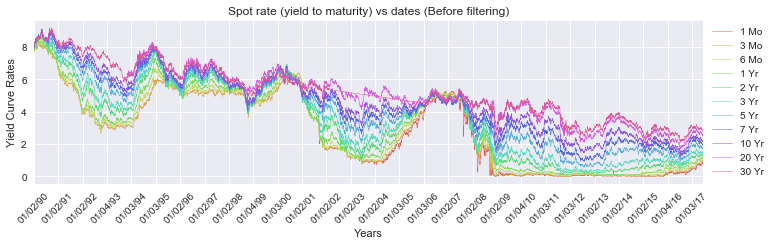

In [4]:
plt.figure(figsize=(12,3))
colors = sns.color_palette("hls", data.shape[1])
for i in range(data.shape[1]):
    temp = [(j,data[:, i][j]) for j in range(len(data[:, i])) if data[:, i][j] > 0]
    #print header[i], "data is missing:", data.shape[0]-len(temp), "out of", data.shape[0]
    
    plt.plot([j[0] for j in temp], [j[1] for j in temp], label=header[i], linewidth=0.5, color=colors[i])
plt.ylabel("Yield Curve Rates")
plt.xlabel("Years")
plt.title("Spot rate (yield to maturity) vs dates (Before filtering)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, data.shape[0])
plt.xticks(locations, ticks, rotation=45)
plt.show()

In [5]:
data = data[:, [1,2,3,4,5,6,7,8]]
header = header[[1,2,3,4,5,6,7,8]]
data = remove0rows(data)

Removed 20


In [6]:
# Taking the first order difference
data2 = differ(np.sqrt(data), 1)

In [7]:
# Rescaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

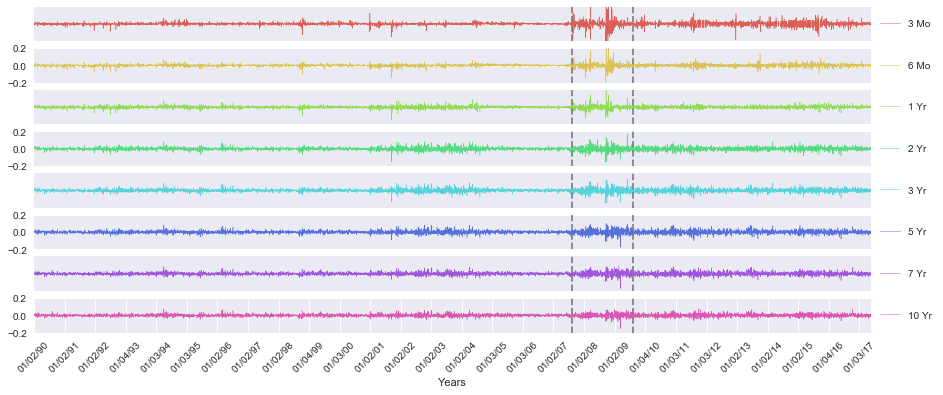

In [8]:
plt.figure(figsize=(15,6))
colors = sns.color_palette("hls", data.shape[1])
for i in range(data2.shape[1]):
    plt.subplot(8,1,i+1)
    plt.plot(data2[:, i], label=header[i], linewidth=0.5, color=colors[i])
    plt.xlim(0, data2.shape[0])
    plt.ylim(-0.2, 0.2)
    if i%2 == 0: 
        plt.yticks([],[])
    plt.xticks([], [])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.axvline(4400, color="gray", ls="--")
    plt.axvline(4900, color="gray", ls="--")
plt.xlabel("Years")
plt.xticks(locations, ticks, rotation=45)
plt.show()

In [20]:
timeseries1 = generate_data(data, futures=[1, 7, 30], interval=10)

In [21]:
pca = PCA(3)
pcaed_data = pca.fit_transform(data)
timeseries2 = generate_data(pcaed_data, futures=[1, 7, 30], interval=10)

In [22]:
timeseries3 = generate_data(data2, futures=[1, 7, 30], interval=10)

# What do we test?

We want to make the ranking of the following models on different time horizon for predicting 3mo maturity yield curve.

Models:
1. RW --> PCAed
3. AR(p) --> PCAed data
4. VAR(p) --> PCAed and Raw
5. 4-layer DNN --> PCAed and Raw
6. 4-layer LSTM --> PCAed and Raw

Horizon:
- 1 day
- 7 days
- 30 days

Metric:
- MSE

In [23]:
results = {}

In [24]:
futures = [1,7,30]

In [25]:
target = 0

# RW

In [90]:
results["RW"] = {}

In [96]:
for f in futures:
    prediction = []
    truth = []
    for fold in range(5):
        ###### Make prediction and truth and append them here ######
        truth += timeseries1[f][fold]["test"][1][:, target].tolist()
        prediction += pca.inverse_transform(timeseries2[f][fold]["test"][0][:, -1, :])[:, target].tolist()
        ############################################################
    prediction = np.array(prediction)
    truth = np.array(truth)
    results["RW"][f] = (MSE(prediction, truth), prediction, truth)

# AR(p)

In [97]:
results["AR(p)"] = {}

In [98]:
for f in futures:
    prediction = []
    truth = []
    for fold in range(5):
        ###### Make prediction and truth and append them here ######
        truth += timeseries1[f][fold]["test"][1][:, target].tolist()
        predicted_pcs = []
        for pc in range(3):
            # individually regress past pcs against the current one.
            y = timeseries2[f][fold]["train"][1][:, pc]
            x = timeseries2[f][fold]["train"][0][:, :, pc]
            lr = sklearn.linear_model.LinearRegression()
            lr.fit(x, y)
            temp = lr.predict(timeseries2[f][fold]["test"][0][:, :, pc])
            predicted_pcs.append(temp.tolist())
        temp = np.transpose(np.array(predicted_pcs))
        prediction += pca.inverse_transform(temp)[:, target].tolist()
        ############################################################
    prediction = np.array(prediction)
    truth = np.array(truth)
    
    results["AR(p)"][f] = (MSE(prediction, truth), prediction, truth)

# VAR(p)-PCA

In [188]:
results["VAR(p)-PCA"] = {}

In [189]:
a = 0.0001
for f in futures:
    prediction = []
    truth = []
    for fold in range(5):
        ###### Make prediction and truth and append them here ######
        truth += timeseries1[f][fold]["test"][1][:, target].tolist()
        
        y = timeseries1[f][fold]["train"][1][:, target]
        x = timeseries2[f][fold]["train"][0]
        x = x.reshape((x.shape[0], x.shape[1]*x.shape[2]))
        
        en = sklearn.linear_model.ElasticNet(alpha = a, max_iter=2000)
        en.fit(x, y)
        #print "Sparcity: ", len([i for i in en.coef_ if i != 0]), "out of", len(en.coef_)
        x2 = timeseries2[f][fold]["test"][0]
        x2 = x2.reshape((x2.shape[0], x2.shape[1]*x2.shape[2]))
        prediction += en.predict(x2).tolist()
        ############################################################
    prediction = np.array(prediction)
    truth = np.array(truth)
    
    results["VAR(p)-PCA"][f] = (MSE(prediction, truth), prediction, truth)

# VAR(p)-RAW

In [190]:
results["VAR(p)-RAW"] = {}

In [191]:
a = 0.0001
for f in futures:
    prediction = []
    truth = []
    for fold in range(5):
        ###### Make prediction and truth and append them here ######
        truth += timeseries1[f][fold]["test"][1][:, target].tolist()
        
        y = timeseries1[f][fold]["train"][1][:, target]
        x = timeseries1[f][fold]["train"][0]
        x = x.reshape((x.shape[0], x.shape[1]*x.shape[2]))
        
        en = sklearn.linear_model.ElasticNet(alpha = a, max_iter=2000)
        en.fit(x, y)
        #print "Sparcity: ", len([i for i in en.coef_ if i != 0]), "out of", len(en.coef_)
        x2 = timeseries1[f][fold]["test"][0]
        x2 = x2.reshape((x2.shape[0], x2.shape[1]*x2.shape[2]))
        prediction += en.predict(x2).tolist()
        ############################################################
    prediction = np.array(prediction)
    truth = np.array(truth)
    
    results["VAR(p)-RAW"][f] = (MSE(prediction, truth), prediction, truth)

# DNN model (4 layers)-RAW

In [135]:
def makeDNN(size):
    model = Sequential()
    model.add(Dense(20, input_shape=(size,)))
    model.add(Activation("tanh"))
    model.add(Dense(10)) 
    model.add(Activation("tanh"))
    model.add(Dense(8))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [142]:
results["DNN"] = {}

In [146]:
a = 0.0001
for f in futures:
    prediction = []
    truth = []
    for fold in range(5):
        ###### Make prediction and truth and append them here ######
        truth += timeseries1[f][fold]["test"][1][:, target].tolist()
        
        y = timeseries1[f][fold]["train"][1]
        x = timeseries1[f][fold]["train"][0]
        x = x.reshape((x.shape[0], x.shape[1]*x.shape[2]))
        
        model = makeDNN(x.shape[1])
        filepath="model/bestDNN_"+str(f)+"_"+str(fold)+".hdf5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        callbacks_list = [checkpoint]
        model.fit(x, y,
          epochs=300, 
          batch_size=256,
          callbacks=callbacks_list,
          validation_split=0.1,
          verbose=0
          )
        
        model = load_model("model/bestDNN"+str(f)+"_"+str(fold)+".hdf5")
        x2 = timeseries1[f][fold]["test"][0]
        x2 = x2.reshape((x2.shape[0], x2.shape[1]*x2.shape[2]))
        prediction += model.predict(x2)[:,target].tolist()
        ############################################################
    prediction = np.array(prediction)
    truth = np.array(truth)
    
    results["DNN"][f] = (MSE(prediction, truth), prediction, truth)

Epoch 00000: val_loss improved from inf to 0.00382, saving model to model/bestDNN1_0.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss improved from 0.00382 to 0.00360, saving model to model/bestDNN1_0.hdf5
Epoch 00007: val_loss improved from 0.00360 to 0.00331, saving model to model/bestDNN1_0.hdf5
Epoch 00008: val_loss improved from 0.00331 to 0.00297, saving model to model/bestDNN1_0.hdf5
Epoch 00009: val_loss improved from 0.00297 to 0.00271, saving model to model/bestDNN1_0.hdf5
Epoch 00010: val_loss improved from 0.00271 to 0.00247, saving model to model/bestDNN1_0.hdf5
Epoch 00011: val_loss improved from 0.00247 to 0.00237, saving model to model/bestDNN1_0.hdf5
Epoch 00012: val_loss improved from 0.00237 to 0.00223, saving model to model/bestDNN1_0.hdf5
Epoch 00013: val_loss improved from 0.00223 to 0.00210, saving

Epoch 00109: val_loss did not improve
Epoch 00110: val_loss did not improve
Epoch 00111: val_loss did not improve
Epoch 00112: val_loss improved from 0.00019 to 0.00018, saving model to model/bestDNN1_0.hdf5
Epoch 00113: val_loss did not improve
Epoch 00114: val_loss did not improve
Epoch 00115: val_loss did not improve
Epoch 00116: val_loss did not improve
Epoch 00117: val_loss improved from 0.00018 to 0.00018, saving model to model/bestDNN1_0.hdf5
Epoch 00118: val_loss did not improve
Epoch 00119: val_loss improved from 0.00018 to 0.00017, saving model to model/bestDNN1_0.hdf5
Epoch 00120: val_loss did not improve
Epoch 00121: val_loss did not improve
Epoch 00122: val_loss improved from 0.00017 to 0.00017, saving model to model/bestDNN1_0.hdf5
Epoch 00123: val_loss did not improve
Epoch 00124: val_loss did not improve
Epoch 00125: val_loss did not improve
Epoch 00126: val_loss improved from 0.00017 to 0.00017, saving model to model/bestDNN1_0.hdf5
Epoch 00127: val_loss did not improv

Epoch 00290: val_loss did not improve
Epoch 00291: val_loss improved from 0.00010 to 0.00010, saving model to model/bestDNN1_0.hdf5
Epoch 00292: val_loss did not improve
Epoch 00293: val_loss did not improve
Epoch 00294: val_loss did not improve
Epoch 00295: val_loss did not improve
Epoch 00296: val_loss did not improve
Epoch 00297: val_loss did not improve
Epoch 00298: val_loss did not improve
Epoch 00299: val_loss did not improve
Epoch 00000: val_loss improved from inf to 0.02132, saving model to model/bestDNN1_1.hdf5
Epoch 00001: val_loss improved from 0.02132 to 0.00956, saving model to model/bestDNN1_1.hdf5
Epoch 00002: val_loss improved from 0.00956 to 0.00762, saving model to model/bestDNN1_1.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_los

Epoch 00094: val_loss did not improve
Epoch 00095: val_loss improved from 0.00064 to 0.00063, saving model to model/bestDNN1_1.hdf5
Epoch 00096: val_loss did not improve
Epoch 00097: val_loss improved from 0.00063 to 0.00061, saving model to model/bestDNN1_1.hdf5
Epoch 00098: val_loss did not improve
Epoch 00099: val_loss improved from 0.00061 to 0.00058, saving model to model/bestDNN1_1.hdf5
Epoch 00100: val_loss improved from 0.00058 to 0.00057, saving model to model/bestDNN1_1.hdf5
Epoch 00101: val_loss did not improve
Epoch 00102: val_loss improved from 0.00057 to 0.00056, saving model to model/bestDNN1_1.hdf5
Epoch 00103: val_loss did not improve
Epoch 00104: val_loss improved from 0.00056 to 0.00054, saving model to model/bestDNN1_1.hdf5
Epoch 00105: val_loss improved from 0.00054 to 0.00054, saving model to model/bestDNN1_1.hdf5
Epoch 00106: val_loss did not improve
Epoch 00107: val_loss improved from 0.00054 to 0.00050, saving model to model/bestDNN1_1.hdf5
Epoch 00108: val_los

Epoch 00226: val_loss did not improve
Epoch 00227: val_loss improved from 0.00017 to 0.00016, saving model to model/bestDNN1_1.hdf5
Epoch 00228: val_loss did not improve
Epoch 00229: val_loss improved from 0.00016 to 0.00016, saving model to model/bestDNN1_1.hdf5
Epoch 00230: val_loss did not improve
Epoch 00231: val_loss improved from 0.00016 to 0.00016, saving model to model/bestDNN1_1.hdf5
Epoch 00232: val_loss did not improve
Epoch 00233: val_loss did not improve
Epoch 00234: val_loss did not improve
Epoch 00235: val_loss improved from 0.00016 to 0.00016, saving model to model/bestDNN1_1.hdf5
Epoch 00236: val_loss improved from 0.00016 to 0.00016, saving model to model/bestDNN1_1.hdf5
Epoch 00237: val_loss did not improve
Epoch 00238: val_loss improved from 0.00016 to 0.00016, saving model to model/bestDNN1_1.hdf5
Epoch 00239: val_loss did not improve
Epoch 00240: val_loss improved from 0.00016 to 0.00015, saving model to model/bestDNN1_1.hdf5
Epoch 00241: val_loss did not improve


Epoch 00060: val_loss did not improve
Epoch 00061: val_loss did not improve
Epoch 00062: val_loss did not improve
Epoch 00063: val_loss did not improve
Epoch 00064: val_loss did not improve
Epoch 00065: val_loss did not improve
Epoch 00066: val_loss did not improve
Epoch 00067: val_loss did not improve
Epoch 00068: val_loss did not improve
Epoch 00069: val_loss did not improve
Epoch 00070: val_loss did not improve
Epoch 00071: val_loss did not improve
Epoch 00072: val_loss did not improve
Epoch 00073: val_loss did not improve
Epoch 00074: val_loss did not improve
Epoch 00075: val_loss did not improve
Epoch 00076: val_loss did not improve
Epoch 00077: val_loss did not improve
Epoch 00078: val_loss did not improve
Epoch 00079: val_loss did not improve
Epoch 00080: val_loss did not improve
Epoch 00081: val_loss did not improve
Epoch 00082: val_loss did not improve
Epoch 00083: val_loss did not improve
Epoch 00084: val_loss did not improve
Epoch 00085: val_loss did not improve
Epoch 00086:

Epoch 00269: val_loss did not improve
Epoch 00270: val_loss did not improve
Epoch 00271: val_loss did not improve
Epoch 00272: val_loss did not improve
Epoch 00273: val_loss did not improve
Epoch 00274: val_loss did not improve
Epoch 00275: val_loss did not improve
Epoch 00276: val_loss did not improve
Epoch 00277: val_loss did not improve
Epoch 00278: val_loss did not improve
Epoch 00279: val_loss did not improve
Epoch 00280: val_loss did not improve
Epoch 00281: val_loss did not improve
Epoch 00282: val_loss improved from 0.00027 to 0.00027, saving model to model/bestDNN1_2.hdf5
Epoch 00283: val_loss did not improve
Epoch 00284: val_loss improved from 0.00027 to 0.00025, saving model to model/bestDNN1_2.hdf5
Epoch 00285: val_loss did not improve
Epoch 00286: val_loss did not improve
Epoch 00287: val_loss did not improve
Epoch 00288: val_loss did not improve
Epoch 00289: val_loss did not improve
Epoch 00290: val_loss did not improve
Epoch 00291: val_loss did not improve
Epoch 00292: v

Epoch 00094: val_loss improved from 0.00029 to 0.00029, saving model to model/bestDNN1_3.hdf5
Epoch 00095: val_loss improved from 0.00029 to 0.00028, saving model to model/bestDNN1_3.hdf5
Epoch 00096: val_loss did not improve
Epoch 00097: val_loss did not improve
Epoch 00098: val_loss improved from 0.00028 to 0.00026, saving model to model/bestDNN1_3.hdf5
Epoch 00099: val_loss did not improve
Epoch 00100: val_loss did not improve
Epoch 00101: val_loss did not improve
Epoch 00102: val_loss did not improve
Epoch 00103: val_loss did not improve
Epoch 00104: val_loss improved from 0.00026 to 0.00025, saving model to model/bestDNN1_3.hdf5
Epoch 00105: val_loss improved from 0.00025 to 0.00025, saving model to model/bestDNN1_3.hdf5
Epoch 00106: val_loss improved from 0.00025 to 0.00024, saving model to model/bestDNN1_3.hdf5
Epoch 00107: val_loss did not improve
Epoch 00108: val_loss improved from 0.00024 to 0.00024, saving model to model/bestDNN1_3.hdf5
Epoch 00109: val_loss did not improve


Epoch 00232: val_loss improved from 0.00012 to 0.00012, saving model to model/bestDNN1_3.hdf5
Epoch 00233: val_loss did not improve
Epoch 00234: val_loss improved from 0.00012 to 0.00012, saving model to model/bestDNN1_3.hdf5
Epoch 00235: val_loss did not improve
Epoch 00236: val_loss did not improve
Epoch 00237: val_loss improved from 0.00012 to 0.00012, saving model to model/bestDNN1_3.hdf5
Epoch 00238: val_loss improved from 0.00012 to 0.00012, saving model to model/bestDNN1_3.hdf5
Epoch 00239: val_loss did not improve
Epoch 00240: val_loss did not improve
Epoch 00241: val_loss did not improve
Epoch 00242: val_loss improved from 0.00012 to 0.00011, saving model to model/bestDNN1_3.hdf5
Epoch 00243: val_loss did not improve
Epoch 00244: val_loss did not improve
Epoch 00245: val_loss did not improve
Epoch 00246: val_loss did not improve
Epoch 00247: val_loss did not improve
Epoch 00248: val_loss improved from 0.00011 to 0.00011, saving model to model/bestDNN1_3.hdf5
Epoch 00249: val_l

Epoch 00058: val_loss did not improve
Epoch 00059: val_loss improved from 0.00123 to 0.00121, saving model to model/bestDNN1_4.hdf5
Epoch 00060: val_loss improved from 0.00121 to 0.00120, saving model to model/bestDNN1_4.hdf5
Epoch 00061: val_loss improved from 0.00120 to 0.00114, saving model to model/bestDNN1_4.hdf5
Epoch 00062: val_loss improved from 0.00114 to 0.00112, saving model to model/bestDNN1_4.hdf5
Epoch 00063: val_loss did not improve
Epoch 00064: val_loss improved from 0.00112 to 0.00110, saving model to model/bestDNN1_4.hdf5
Epoch 00065: val_loss improved from 0.00110 to 0.00108, saving model to model/bestDNN1_4.hdf5
Epoch 00066: val_loss improved from 0.00108 to 0.00104, saving model to model/bestDNN1_4.hdf5
Epoch 00067: val_loss improved from 0.00104 to 0.00104, saving model to model/bestDNN1_4.hdf5
Epoch 00068: val_loss improved from 0.00104 to 0.00100, saving model to model/bestDNN1_4.hdf5
Epoch 00069: val_loss improved from 0.00100 to 0.00098, saving model to model/

Epoch 00175: val_loss did not improve
Epoch 00176: val_loss did not improve
Epoch 00177: val_loss did not improve
Epoch 00178: val_loss did not improve
Epoch 00179: val_loss improved from 0.00033 to 0.00033, saving model to model/bestDNN1_4.hdf5
Epoch 00180: val_loss did not improve
Epoch 00181: val_loss improved from 0.00033 to 0.00033, saving model to model/bestDNN1_4.hdf5
Epoch 00182: val_loss did not improve
Epoch 00183: val_loss improved from 0.00033 to 0.00032, saving model to model/bestDNN1_4.hdf5
Epoch 00184: val_loss did not improve
Epoch 00185: val_loss improved from 0.00032 to 0.00031, saving model to model/bestDNN1_4.hdf5
Epoch 00186: val_loss did not improve
Epoch 00187: val_loss did not improve
Epoch 00188: val_loss did not improve
Epoch 00189: val_loss did not improve
Epoch 00190: val_loss did not improve
Epoch 00191: val_loss did not improve
Epoch 00192: val_loss did not improve
Epoch 00193: val_loss did not improve
Epoch 00194: val_loss improved from 0.00031 to 0.00030

Epoch 00027: val_loss improved from 0.00134 to 0.00131, saving model to model/bestDNN7_0.hdf5
Epoch 00028: val_loss improved from 0.00131 to 0.00128, saving model to model/bestDNN7_0.hdf5
Epoch 00029: val_loss improved from 0.00128 to 0.00124, saving model to model/bestDNN7_0.hdf5
Epoch 00030: val_loss improved from 0.00124 to 0.00124, saving model to model/bestDNN7_0.hdf5
Epoch 00031: val_loss improved from 0.00124 to 0.00119, saving model to model/bestDNN7_0.hdf5
Epoch 00032: val_loss improved from 0.00119 to 0.00114, saving model to model/bestDNN7_0.hdf5
Epoch 00033: val_loss improved from 0.00114 to 0.00114, saving model to model/bestDNN7_0.hdf5
Epoch 00034: val_loss improved from 0.00114 to 0.00113, saving model to model/bestDNN7_0.hdf5
Epoch 00035: val_loss improved from 0.00113 to 0.00110, saving model to model/bestDNN7_0.hdf5
Epoch 00036: val_loss improved from 0.00110 to 0.00108, saving model to model/bestDNN7_0.hdf5
Epoch 00037: val_loss improved from 0.00108 to 0.00106, savi

Epoch 00148: val_loss did not improve
Epoch 00149: val_loss improved from 0.00034 to 0.00034, saving model to model/bestDNN7_0.hdf5
Epoch 00150: val_loss did not improve
Epoch 00151: val_loss did not improve
Epoch 00152: val_loss improved from 0.00034 to 0.00034, saving model to model/bestDNN7_0.hdf5
Epoch 00153: val_loss did not improve
Epoch 00154: val_loss did not improve
Epoch 00155: val_loss improved from 0.00034 to 0.00033, saving model to model/bestDNN7_0.hdf5
Epoch 00156: val_loss did not improve
Epoch 00157: val_loss did not improve
Epoch 00158: val_loss did not improve
Epoch 00159: val_loss did not improve
Epoch 00160: val_loss improved from 0.00033 to 0.00032, saving model to model/bestDNN7_0.hdf5
Epoch 00161: val_loss did not improve
Epoch 00162: val_loss improved from 0.00032 to 0.00032, saving model to model/bestDNN7_0.hdf5
Epoch 00163: val_loss improved from 0.00032 to 0.00031, saving model to model/bestDNN7_0.hdf5
Epoch 00164: val_loss did not improve
Epoch 00165: val_l

Epoch 00022: val_loss improved from 0.00202 to 0.00188, saving model to model/bestDNN7_1.hdf5
Epoch 00023: val_loss improved from 0.00188 to 0.00188, saving model to model/bestDNN7_1.hdf5
Epoch 00024: val_loss improved from 0.00188 to 0.00177, saving model to model/bestDNN7_1.hdf5
Epoch 00025: val_loss did not improve
Epoch 00026: val_loss improved from 0.00177 to 0.00170, saving model to model/bestDNN7_1.hdf5
Epoch 00027: val_loss improved from 0.00170 to 0.00162, saving model to model/bestDNN7_1.hdf5
Epoch 00028: val_loss improved from 0.00162 to 0.00155, saving model to model/bestDNN7_1.hdf5
Epoch 00029: val_loss improved from 0.00155 to 0.00147, saving model to model/bestDNN7_1.hdf5
Epoch 00030: val_loss did not improve
Epoch 00031: val_loss improved from 0.00147 to 0.00143, saving model to model/bestDNN7_1.hdf5
Epoch 00032: val_loss improved from 0.00143 to 0.00139, saving model to model/bestDNN7_1.hdf5
Epoch 00033: val_loss did not improve
Epoch 00034: val_loss improved from 0.00

Epoch 00163: val_loss did not improve
Epoch 00164: val_loss did not improve
Epoch 00165: val_loss did not improve
Epoch 00166: val_loss did not improve
Epoch 00167: val_loss did not improve
Epoch 00168: val_loss did not improve
Epoch 00169: val_loss did not improve
Epoch 00170: val_loss did not improve
Epoch 00171: val_loss did not improve
Epoch 00172: val_loss did not improve
Epoch 00173: val_loss did not improve
Epoch 00174: val_loss did not improve
Epoch 00175: val_loss did not improve
Epoch 00176: val_loss improved from 0.00026 to 0.00026, saving model to model/bestDNN7_1.hdf5
Epoch 00177: val_loss did not improve
Epoch 00178: val_loss did not improve
Epoch 00179: val_loss did not improve
Epoch 00180: val_loss did not improve
Epoch 00181: val_loss did not improve
Epoch 00182: val_loss did not improve
Epoch 00183: val_loss did not improve
Epoch 00184: val_loss did not improve
Epoch 00185: val_loss did not improve
Epoch 00186: val_loss did not improve
Epoch 00187: val_loss did not im

Epoch 00033: val_loss did not improve
Epoch 00034: val_loss improved from 0.00128 to 0.00122, saving model to model/bestDNN7_2.hdf5
Epoch 00035: val_loss improved from 0.00122 to 0.00118, saving model to model/bestDNN7_2.hdf5
Epoch 00036: val_loss did not improve
Epoch 00037: val_loss improved from 0.00118 to 0.00108, saving model to model/bestDNN7_2.hdf5
Epoch 00038: val_loss improved from 0.00108 to 0.00107, saving model to model/bestDNN7_2.hdf5
Epoch 00039: val_loss improved from 0.00107 to 0.00106, saving model to model/bestDNN7_2.hdf5
Epoch 00040: val_loss improved from 0.00106 to 0.00102, saving model to model/bestDNN7_2.hdf5
Epoch 00041: val_loss improved from 0.00102 to 0.00099, saving model to model/bestDNN7_2.hdf5
Epoch 00042: val_loss improved from 0.00099 to 0.00097, saving model to model/bestDNN7_2.hdf5
Epoch 00043: val_loss improved from 0.00097 to 0.00095, saving model to model/bestDNN7_2.hdf5
Epoch 00044: val_loss improved from 0.00095 to 0.00092, saving model to model/

Epoch 00169: val_loss did not improve
Epoch 00170: val_loss did not improve
Epoch 00171: val_loss did not improve
Epoch 00172: val_loss did not improve
Epoch 00173: val_loss did not improve
Epoch 00174: val_loss improved from 0.00027 to 0.00027, saving model to model/bestDNN7_2.hdf5
Epoch 00175: val_loss did not improve
Epoch 00176: val_loss did not improve
Epoch 00177: val_loss improved from 0.00027 to 0.00026, saving model to model/bestDNN7_2.hdf5
Epoch 00178: val_loss did not improve
Epoch 00179: val_loss did not improve
Epoch 00180: val_loss did not improve
Epoch 00181: val_loss did not improve
Epoch 00182: val_loss improved from 0.00026 to 0.00026, saving model to model/bestDNN7_2.hdf5
Epoch 00183: val_loss improved from 0.00026 to 0.00025, saving model to model/bestDNN7_2.hdf5
Epoch 00184: val_loss did not improve
Epoch 00185: val_loss did not improve
Epoch 00186: val_loss did not improve
Epoch 00187: val_loss improved from 0.00025 to 0.00025, saving model to model/bestDNN7_2.hdf

Epoch 00017: val_loss improved from 0.00147 to 0.00142, saving model to model/bestDNN7_3.hdf5
Epoch 00018: val_loss improved from 0.00142 to 0.00139, saving model to model/bestDNN7_3.hdf5
Epoch 00019: val_loss improved from 0.00139 to 0.00135, saving model to model/bestDNN7_3.hdf5
Epoch 00020: val_loss improved from 0.00135 to 0.00133, saving model to model/bestDNN7_3.hdf5
Epoch 00021: val_loss improved from 0.00133 to 0.00129, saving model to model/bestDNN7_3.hdf5
Epoch 00022: val_loss improved from 0.00129 to 0.00125, saving model to model/bestDNN7_3.hdf5
Epoch 00023: val_loss improved from 0.00125 to 0.00125, saving model to model/bestDNN7_3.hdf5
Epoch 00024: val_loss improved from 0.00125 to 0.00122, saving model to model/bestDNN7_3.hdf5
Epoch 00025: val_loss did not improve
Epoch 00026: val_loss did not improve
Epoch 00027: val_loss improved from 0.00122 to 0.00121, saving model to model/bestDNN7_3.hdf5
Epoch 00028: val_loss did not improve
Epoch 00029: val_loss did not improve
Ep

Epoch 00199: val_loss did not improve
Epoch 00200: val_loss did not improve
Epoch 00201: val_loss did not improve
Epoch 00202: val_loss did not improve
Epoch 00203: val_loss did not improve
Epoch 00204: val_loss did not improve
Epoch 00205: val_loss did not improve
Epoch 00206: val_loss did not improve
Epoch 00207: val_loss did not improve
Epoch 00208: val_loss did not improve
Epoch 00209: val_loss did not improve
Epoch 00210: val_loss did not improve
Epoch 00211: val_loss did not improve
Epoch 00212: val_loss did not improve
Epoch 00213: val_loss did not improve
Epoch 00214: val_loss did not improve
Epoch 00215: val_loss did not improve
Epoch 00216: val_loss did not improve
Epoch 00217: val_loss did not improve
Epoch 00218: val_loss did not improve
Epoch 00219: val_loss did not improve
Epoch 00220: val_loss improved from 0.00067 to 0.00067, saving model to model/bestDNN7_3.hdf5
Epoch 00221: val_loss did not improve
Epoch 00222: val_loss improved from 0.00067 to 0.00061, saving model t

Epoch 00045: val_loss improved from 0.00208 to 0.00203, saving model to model/bestDNN7_4.hdf5
Epoch 00046: val_loss improved from 0.00203 to 0.00200, saving model to model/bestDNN7_4.hdf5
Epoch 00047: val_loss improved from 0.00200 to 0.00200, saving model to model/bestDNN7_4.hdf5
Epoch 00048: val_loss improved from 0.00200 to 0.00194, saving model to model/bestDNN7_4.hdf5
Epoch 00049: val_loss did not improve
Epoch 00050: val_loss improved from 0.00194 to 0.00188, saving model to model/bestDNN7_4.hdf5
Epoch 00051: val_loss improved from 0.00188 to 0.00187, saving model to model/bestDNN7_4.hdf5
Epoch 00052: val_loss improved from 0.00187 to 0.00182, saving model to model/bestDNN7_4.hdf5
Epoch 00053: val_loss did not improve
Epoch 00054: val_loss improved from 0.00182 to 0.00175, saving model to model/bestDNN7_4.hdf5
Epoch 00055: val_loss improved from 0.00175 to 0.00174, saving model to model/bestDNN7_4.hdf5
Epoch 00056: val_loss did not improve
Epoch 00057: val_loss improved from 0.00

Epoch 00167: val_loss did not improve
Epoch 00168: val_loss did not improve
Epoch 00169: val_loss did not improve
Epoch 00170: val_loss improved from 0.00089 to 0.00089, saving model to model/bestDNN7_4.hdf5
Epoch 00171: val_loss improved from 0.00089 to 0.00089, saving model to model/bestDNN7_4.hdf5
Epoch 00172: val_loss improved from 0.00089 to 0.00086, saving model to model/bestDNN7_4.hdf5
Epoch 00173: val_loss did not improve
Epoch 00174: val_loss did not improve
Epoch 00175: val_loss did not improve
Epoch 00176: val_loss did not improve
Epoch 00177: val_loss improved from 0.00086 to 0.00086, saving model to model/bestDNN7_4.hdf5
Epoch 00178: val_loss did not improve
Epoch 00179: val_loss did not improve
Epoch 00180: val_loss did not improve
Epoch 00181: val_loss did not improve
Epoch 00182: val_loss improved from 0.00086 to 0.00085, saving model to model/bestDNN7_4.hdf5
Epoch 00183: val_loss improved from 0.00085 to 0.00085, saving model to model/bestDNN7_4.hdf5
Epoch 00184: val_l

Epoch 00022: val_loss improved from 0.00196 to 0.00191, saving model to model/bestDNN30_0.hdf5
Epoch 00023: val_loss improved from 0.00191 to 0.00188, saving model to model/bestDNN30_0.hdf5
Epoch 00024: val_loss improved from 0.00188 to 0.00183, saving model to model/bestDNN30_0.hdf5
Epoch 00025: val_loss improved from 0.00183 to 0.00178, saving model to model/bestDNN30_0.hdf5
Epoch 00026: val_loss improved from 0.00178 to 0.00177, saving model to model/bestDNN30_0.hdf5
Epoch 00027: val_loss improved from 0.00177 to 0.00168, saving model to model/bestDNN30_0.hdf5
Epoch 00028: val_loss did not improve
Epoch 00029: val_loss improved from 0.00168 to 0.00162, saving model to model/bestDNN30_0.hdf5
Epoch 00030: val_loss improved from 0.00162 to 0.00160, saving model to model/bestDNN30_0.hdf5
Epoch 00031: val_loss did not improve
Epoch 00032: val_loss improved from 0.00160 to 0.00152, saving model to model/bestDNN30_0.hdf5
Epoch 00033: val_loss improved from 0.00152 to 0.00148, saving model 

Epoch 00172: val_loss did not improve
Epoch 00173: val_loss did not improve
Epoch 00174: val_loss did not improve
Epoch 00175: val_loss did not improve
Epoch 00176: val_loss did not improve
Epoch 00177: val_loss did not improve
Epoch 00178: val_loss did not improve
Epoch 00179: val_loss did not improve
Epoch 00180: val_loss did not improve
Epoch 00181: val_loss did not improve
Epoch 00182: val_loss did not improve
Epoch 00183: val_loss did not improve
Epoch 00184: val_loss did not improve
Epoch 00185: val_loss did not improve
Epoch 00186: val_loss did not improve
Epoch 00187: val_loss improved from 0.00067 to 0.00067, saving model to model/bestDNN30_0.hdf5
Epoch 00188: val_loss did not improve
Epoch 00189: val_loss did not improve
Epoch 00190: val_loss did not improve
Epoch 00191: val_loss did not improve
Epoch 00192: val_loss did not improve
Epoch 00193: val_loss did not improve
Epoch 00194: val_loss did not improve
Epoch 00195: val_loss did not improve
Epoch 00196: val_loss did not i

Epoch 00036: val_loss improved from 0.00109 to 0.00109, saving model to model/bestDNN30_1.hdf5
Epoch 00037: val_loss did not improve
Epoch 00038: val_loss improved from 0.00109 to 0.00107, saving model to model/bestDNN30_1.hdf5
Epoch 00039: val_loss did not improve
Epoch 00040: val_loss improved from 0.00107 to 0.00107, saving model to model/bestDNN30_1.hdf5
Epoch 00041: val_loss did not improve
Epoch 00042: val_loss improved from 0.00107 to 0.00104, saving model to model/bestDNN30_1.hdf5
Epoch 00043: val_loss did not improve
Epoch 00044: val_loss did not improve
Epoch 00045: val_loss improved from 0.00104 to 0.00103, saving model to model/bestDNN30_1.hdf5
Epoch 00046: val_loss did not improve
Epoch 00047: val_loss did not improve
Epoch 00048: val_loss did not improve
Epoch 00049: val_loss did not improve
Epoch 00050: val_loss did not improve
Epoch 00051: val_loss improved from 0.00103 to 0.00103, saving model to model/bestDNN30_1.hdf5
Epoch 00052: val_loss improved from 0.00103 to 0.0

Epoch 00198: val_loss did not improve
Epoch 00199: val_loss did not improve
Epoch 00200: val_loss did not improve
Epoch 00201: val_loss did not improve
Epoch 00202: val_loss did not improve
Epoch 00203: val_loss did not improve
Epoch 00204: val_loss did not improve
Epoch 00205: val_loss did not improve
Epoch 00206: val_loss did not improve
Epoch 00207: val_loss did not improve
Epoch 00208: val_loss did not improve
Epoch 00209: val_loss did not improve
Epoch 00210: val_loss improved from 0.00073 to 0.00072, saving model to model/bestDNN30_1.hdf5
Epoch 00211: val_loss did not improve
Epoch 00212: val_loss did not improve
Epoch 00213: val_loss improved from 0.00072 to 0.00071, saving model to model/bestDNN30_1.hdf5
Epoch 00214: val_loss did not improve
Epoch 00215: val_loss did not improve
Epoch 00216: val_loss did not improve
Epoch 00217: val_loss did not improve
Epoch 00218: val_loss did not improve
Epoch 00219: val_loss did not improve
Epoch 00220: val_loss did not improve
Epoch 00221:

Epoch 00070: val_loss did not improve
Epoch 00071: val_loss did not improve
Epoch 00072: val_loss did not improve
Epoch 00073: val_loss did not improve
Epoch 00074: val_loss did not improve
Epoch 00075: val_loss did not improve
Epoch 00076: val_loss did not improve
Epoch 00077: val_loss improved from 0.00179 to 0.00179, saving model to model/bestDNN30_2.hdf5
Epoch 00078: val_loss improved from 0.00179 to 0.00166, saving model to model/bestDNN30_2.hdf5
Epoch 00079: val_loss did not improve
Epoch 00080: val_loss did not improve
Epoch 00081: val_loss did not improve
Epoch 00082: val_loss did not improve
Epoch 00083: val_loss improved from 0.00166 to 0.00160, saving model to model/bestDNN30_2.hdf5
Epoch 00084: val_loss did not improve
Epoch 00085: val_loss improved from 0.00160 to 0.00155, saving model to model/bestDNN30_2.hdf5
Epoch 00086: val_loss did not improve
Epoch 00087: val_loss did not improve
Epoch 00088: val_loss did not improve
Epoch 00089: val_loss did not improve
Epoch 00090:

Epoch 00248: val_loss did not improve
Epoch 00249: val_loss did not improve
Epoch 00250: val_loss did not improve
Epoch 00251: val_loss did not improve
Epoch 00252: val_loss did not improve
Epoch 00253: val_loss did not improve
Epoch 00254: val_loss did not improve
Epoch 00255: val_loss did not improve
Epoch 00256: val_loss did not improve
Epoch 00257: val_loss did not improve
Epoch 00258: val_loss did not improve
Epoch 00259: val_loss did not improve
Epoch 00260: val_loss did not improve
Epoch 00261: val_loss did not improve
Epoch 00262: val_loss did not improve
Epoch 00263: val_loss did not improve
Epoch 00264: val_loss did not improve
Epoch 00265: val_loss did not improve
Epoch 00266: val_loss did not improve
Epoch 00267: val_loss did not improve
Epoch 00268: val_loss did not improve
Epoch 00269: val_loss did not improve
Epoch 00270: val_loss did not improve
Epoch 00271: val_loss did not improve
Epoch 00272: val_loss did not improve
Epoch 00273: val_loss did not improve
Epoch 00274:

Epoch 00076: val_loss improved from 0.00134 to 0.00132, saving model to model/bestDNN30_3.hdf5
Epoch 00077: val_loss did not improve
Epoch 00078: val_loss did not improve
Epoch 00079: val_loss did not improve
Epoch 00080: val_loss did not improve
Epoch 00081: val_loss did not improve
Epoch 00082: val_loss did not improve
Epoch 00083: val_loss did not improve
Epoch 00084: val_loss did not improve
Epoch 00085: val_loss did not improve
Epoch 00086: val_loss did not improve
Epoch 00087: val_loss did not improve
Epoch 00088: val_loss improved from 0.00132 to 0.00130, saving model to model/bestDNN30_3.hdf5
Epoch 00089: val_loss did not improve
Epoch 00090: val_loss did not improve
Epoch 00091: val_loss did not improve
Epoch 00092: val_loss did not improve
Epoch 00093: val_loss did not improve
Epoch 00094: val_loss did not improve
Epoch 00095: val_loss did not improve
Epoch 00096: val_loss did not improve
Epoch 00097: val_loss did not improve
Epoch 00098: val_loss did not improve
Epoch 00099:

Epoch 00286: val_loss did not improve
Epoch 00287: val_loss did not improve
Epoch 00288: val_loss did not improve
Epoch 00289: val_loss did not improve
Epoch 00290: val_loss did not improve
Epoch 00291: val_loss did not improve
Epoch 00292: val_loss did not improve
Epoch 00293: val_loss did not improve
Epoch 00294: val_loss did not improve
Epoch 00295: val_loss did not improve
Epoch 00296: val_loss did not improve
Epoch 00297: val_loss did not improve
Epoch 00298: val_loss did not improve
Epoch 00299: val_loss did not improve
Epoch 00000: val_loss improved from inf to 0.02216, saving model to model/bestDNN30_4.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss improved from 0.02216 to 0.02026, saving model to model/bestDNN30_4.hdf5
Epoch 00004: val_loss improved from 0.02026 to 0.01583, saving model to model/bestDNN30_4.hdf5
Epoch 00005: val_loss improved from 0.01583 to 0.01254, saving model to model/bestDNN30_4.hdf5
Epoch 00006: val

Epoch 00128: val_loss did not improve
Epoch 00129: val_loss did not improve
Epoch 00130: val_loss did not improve
Epoch 00131: val_loss did not improve
Epoch 00132: val_loss did not improve
Epoch 00133: val_loss did not improve
Epoch 00134: val_loss did not improve
Epoch 00135: val_loss did not improve
Epoch 00136: val_loss did not improve
Epoch 00137: val_loss did not improve
Epoch 00138: val_loss did not improve
Epoch 00139: val_loss did not improve
Epoch 00140: val_loss did not improve
Epoch 00141: val_loss did not improve
Epoch 00142: val_loss did not improve
Epoch 00143: val_loss did not improve
Epoch 00144: val_loss did not improve
Epoch 00145: val_loss did not improve
Epoch 00146: val_loss did not improve
Epoch 00147: val_loss did not improve
Epoch 00148: val_loss did not improve
Epoch 00149: val_loss did not improve
Epoch 00150: val_loss did not improve
Epoch 00151: val_loss did not improve
Epoch 00152: val_loss did not improve
Epoch 00153: val_loss did not improve
Epoch 00154:

# DNN model (feature selected by VAR)

In [161]:
results["DNN-VAR"] = {}

In [170]:
a = 0.0001
for f in futures:
    prediction = []
    truth = []
    for fold in range(5):
        ###### Make prediction and truth and append them here ######
        truth += timeseries1[f][fold]["test"][1][:, target].tolist()
        
        y = timeseries1[f][fold]["train"][1]
        x = timeseries1[f][fold]["train"][0]
        x = x.reshape((x.shape[0], x.shape[1]*x.shape[2]))
        
        en = sklearn.linear_model.ElasticNet(alpha = a, max_iter=2000)
        en.fit(x, y[:,target])
        mask = (en.coef_!=0).astype(np.bool_)
        
        model = makeDNN(np.sum(mask))
        filepath="model/bestDNN_VAR"+str(f)+"_"+str(fold)+".hdf5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        callbacks_list = [checkpoint]
        
        model.fit(x[:, mask], y,
          epochs=300, 
          batch_size=256,
          callbacks=callbacks_list,
          validation_split=0.1,
          verbose=0
          )
        
        model = load_model("model/bestDNN_VAR"+str(f)+"_"+str(fold)+".hdf5")
        x2 = timeseries1[f][fold]["test"][0]
        x2 = x2.reshape((x2.shape[0], x2.shape[1]*x2.shape[2]))
        prediction += model.predict(x2[:, mask])[:,target].tolist()
        ############################################################
    prediction = np.array(prediction)
    truth = np.array(truth)
    
    results["DNN-VAR"][f] = (MSE(prediction, truth), prediction, truth)

Epoch 00000: val_loss improved from inf to 0.00671, saving model to model/bestDNN_VAR1_0.hdf5
Epoch 00001: val_loss improved from 0.00671 to 0.00547, saving model to model/bestDNN_VAR1_0.hdf5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss improved from 0.00547 to 0.00485, saving model to model/bestDNN_VAR1_0.hdf5
Epoch 00012: val_loss improved from 0.00485 to 0.00423, saving model to model/bestDNN_VAR1_0.hdf5
Epoch 00013: val_loss improved from 0.00423 to 0.00377, saving model to model/bestDNN_VAR1_0.hdf5
Epoch 00014: val_loss improved from 0.00377 to 0.00350, saving model to model/bestDNN_VAR1_0.hdf5
Epoch 00015: val_loss improved from 0.00350 to 0.00337, saving model to mo

Epoch 00200: val_loss did not improve
Epoch 00201: val_loss did not improve
Epoch 00202: val_loss did not improve
Epoch 00203: val_loss did not improve
Epoch 00204: val_loss did not improve
Epoch 00205: val_loss did not improve
Epoch 00206: val_loss did not improve
Epoch 00207: val_loss did not improve
Epoch 00208: val_loss did not improve
Epoch 00209: val_loss did not improve
Epoch 00210: val_loss did not improve
Epoch 00211: val_loss did not improve
Epoch 00212: val_loss did not improve
Epoch 00213: val_loss did not improve
Epoch 00214: val_loss did not improve
Epoch 00215: val_loss did not improve
Epoch 00216: val_loss did not improve
Epoch 00217: val_loss did not improve
Epoch 00218: val_loss did not improve
Epoch 00219: val_loss did not improve
Epoch 00220: val_loss did not improve
Epoch 00221: val_loss did not improve
Epoch 00222: val_loss did not improve
Epoch 00223: val_loss did not improve
Epoch 00224: val_loss did not improve
Epoch 00225: val_loss did not improve
Epoch 00226:

Epoch 00117: val_loss did not improve
Epoch 00118: val_loss did not improve
Epoch 00119: val_loss did not improve
Epoch 00120: val_loss did not improve
Epoch 00121: val_loss did not improve
Epoch 00122: val_loss did not improve
Epoch 00123: val_loss did not improve
Epoch 00124: val_loss did not improve
Epoch 00125: val_loss did not improve
Epoch 00126: val_loss did not improve
Epoch 00127: val_loss did not improve
Epoch 00128: val_loss did not improve
Epoch 00129: val_loss did not improve
Epoch 00130: val_loss did not improve
Epoch 00131: val_loss did not improve
Epoch 00132: val_loss did not improve
Epoch 00133: val_loss did not improve
Epoch 00134: val_loss did not improve
Epoch 00135: val_loss did not improve
Epoch 00136: val_loss did not improve
Epoch 00137: val_loss did not improve
Epoch 00138: val_loss did not improve
Epoch 00139: val_loss did not improve
Epoch 00140: val_loss did not improve
Epoch 00141: val_loss did not improve
Epoch 00142: val_loss did not improve
Epoch 00143:

Epoch 00017: val_loss did not improve
Epoch 00018: val_loss improved from 0.00215 to 0.00214, saving model to model/bestDNN_VAR1_2.hdf5
Epoch 00019: val_loss did not improve
Epoch 00020: val_loss did not improve
Epoch 00021: val_loss did not improve
Epoch 00022: val_loss did not improve
Epoch 00023: val_loss did not improve
Epoch 00024: val_loss did not improve
Epoch 00025: val_loss did not improve
Epoch 00026: val_loss did not improve
Epoch 00027: val_loss did not improve
Epoch 00028: val_loss did not improve
Epoch 00029: val_loss did not improve
Epoch 00030: val_loss did not improve
Epoch 00031: val_loss did not improve
Epoch 00032: val_loss did not improve
Epoch 00033: val_loss did not improve
Epoch 00034: val_loss did not improve
Epoch 00035: val_loss did not improve
Epoch 00036: val_loss did not improve
Epoch 00037: val_loss did not improve
Epoch 00038: val_loss did not improve
Epoch 00039: val_loss did not improve
Epoch 00040: val_loss did not improve
Epoch 00041: val_loss did no

Epoch 00234: val_loss did not improve
Epoch 00235: val_loss did not improve
Epoch 00236: val_loss did not improve
Epoch 00237: val_loss did not improve
Epoch 00238: val_loss did not improve
Epoch 00239: val_loss did not improve
Epoch 00240: val_loss did not improve
Epoch 00241: val_loss did not improve
Epoch 00242: val_loss did not improve
Epoch 00243: val_loss did not improve
Epoch 00244: val_loss did not improve
Epoch 00245: val_loss did not improve
Epoch 00246: val_loss did not improve
Epoch 00247: val_loss did not improve
Epoch 00248: val_loss did not improve
Epoch 00249: val_loss did not improve
Epoch 00250: val_loss did not improve
Epoch 00251: val_loss did not improve
Epoch 00252: val_loss did not improve
Epoch 00253: val_loss did not improve
Epoch 00254: val_loss did not improve
Epoch 00255: val_loss did not improve
Epoch 00256: val_loss did not improve
Epoch 00257: val_loss did not improve
Epoch 00258: val_loss did not improve
Epoch 00259: val_loss did not improve
Epoch 00260:

Epoch 00112: val_loss did not improve
Epoch 00113: val_loss did not improve
Epoch 00114: val_loss improved from 0.00102 to 0.00102, saving model to model/bestDNN_VAR1_3.hdf5
Epoch 00115: val_loss improved from 0.00102 to 0.00101, saving model to model/bestDNN_VAR1_3.hdf5
Epoch 00116: val_loss improved from 0.00101 to 0.00100, saving model to model/bestDNN_VAR1_3.hdf5
Epoch 00117: val_loss did not improve
Epoch 00118: val_loss did not improve
Epoch 00119: val_loss improved from 0.00100 to 0.00098, saving model to model/bestDNN_VAR1_3.hdf5
Epoch 00120: val_loss improved from 0.00098 to 0.00095, saving model to model/bestDNN_VAR1_3.hdf5
Epoch 00121: val_loss did not improve
Epoch 00122: val_loss improved from 0.00095 to 0.00093, saving model to model/bestDNN_VAR1_3.hdf5
Epoch 00123: val_loss did not improve
Epoch 00124: val_loss improved from 0.00093 to 0.00092, saving model to model/bestDNN_VAR1_3.hdf5
Epoch 00125: val_loss did not improve
Epoch 00126: val_loss improved from 0.00092 to 0

Epoch 00277: val_loss did not improve
Epoch 00278: val_loss did not improve
Epoch 00279: val_loss did not improve
Epoch 00280: val_loss did not improve
Epoch 00281: val_loss did not improve
Epoch 00282: val_loss did not improve
Epoch 00283: val_loss did not improve
Epoch 00284: val_loss did not improve
Epoch 00285: val_loss did not improve
Epoch 00286: val_loss did not improve
Epoch 00287: val_loss did not improve
Epoch 00288: val_loss did not improve
Epoch 00289: val_loss did not improve
Epoch 00290: val_loss improved from 0.00047 to 0.00047, saving model to model/bestDNN_VAR1_3.hdf5
Epoch 00291: val_loss did not improve
Epoch 00292: val_loss did not improve
Epoch 00293: val_loss did not improve
Epoch 00294: val_loss did not improve
Epoch 00295: val_loss did not improve
Epoch 00296: val_loss did not improve
Epoch 00297: val_loss did not improve
Epoch 00298: val_loss did not improve
Epoch 00299: val_loss did not improve
Epoch 00000: val_loss improved from inf to 0.00979, saving model t

Epoch 00145: val_loss did not improve
Epoch 00146: val_loss did not improve
Epoch 00147: val_loss did not improve
Epoch 00148: val_loss did not improve
Epoch 00149: val_loss did not improve
Epoch 00150: val_loss did not improve
Epoch 00151: val_loss did not improve
Epoch 00152: val_loss did not improve
Epoch 00153: val_loss did not improve
Epoch 00154: val_loss did not improve
Epoch 00155: val_loss did not improve
Epoch 00156: val_loss did not improve
Epoch 00157: val_loss did not improve
Epoch 00158: val_loss did not improve
Epoch 00159: val_loss did not improve
Epoch 00160: val_loss did not improve
Epoch 00161: val_loss did not improve
Epoch 00162: val_loss did not improve
Epoch 00163: val_loss did not improve
Epoch 00164: val_loss did not improve
Epoch 00165: val_loss did not improve
Epoch 00166: val_loss did not improve
Epoch 00167: val_loss did not improve
Epoch 00168: val_loss did not improve
Epoch 00169: val_loss did not improve
Epoch 00170: val_loss did not improve
Epoch 00171:

Epoch 00046: val_loss improved from 0.00144 to 0.00141, saving model to model/bestDNN_VAR7_0.hdf5
Epoch 00047: val_loss improved from 0.00141 to 0.00137, saving model to model/bestDNN_VAR7_0.hdf5
Epoch 00048: val_loss improved from 0.00137 to 0.00131, saving model to model/bestDNN_VAR7_0.hdf5
Epoch 00049: val_loss improved from 0.00131 to 0.00128, saving model to model/bestDNN_VAR7_0.hdf5
Epoch 00050: val_loss improved from 0.00128 to 0.00124, saving model to model/bestDNN_VAR7_0.hdf5
Epoch 00051: val_loss improved from 0.00124 to 0.00120, saving model to model/bestDNN_VAR7_0.hdf5
Epoch 00052: val_loss improved from 0.00120 to 0.00117, saving model to model/bestDNN_VAR7_0.hdf5
Epoch 00053: val_loss improved from 0.00117 to 0.00113, saving model to model/bestDNN_VAR7_0.hdf5
Epoch 00054: val_loss improved from 0.00113 to 0.00110, saving model to model/bestDNN_VAR7_0.hdf5
Epoch 00055: val_loss improved from 0.00110 to 0.00109, saving model to model/bestDNN_VAR7_0.hdf5
Epoch 00056: val_los

Epoch 00163: val_loss improved from 0.00043 to 0.00041, saving model to model/bestDNN_VAR7_0.hdf5
Epoch 00164: val_loss did not improve
Epoch 00165: val_loss did not improve
Epoch 00166: val_loss did not improve
Epoch 00167: val_loss did not improve
Epoch 00168: val_loss did not improve
Epoch 00169: val_loss improved from 0.00041 to 0.00040, saving model to model/bestDNN_VAR7_0.hdf5
Epoch 00170: val_loss did not improve
Epoch 00171: val_loss did not improve
Epoch 00172: val_loss did not improve
Epoch 00173: val_loss did not improve
Epoch 00174: val_loss did not improve
Epoch 00175: val_loss did not improve
Epoch 00176: val_loss did not improve
Epoch 00177: val_loss did not improve
Epoch 00178: val_loss did not improve
Epoch 00179: val_loss improved from 0.00040 to 0.00040, saving model to model/bestDNN_VAR7_0.hdf5
Epoch 00180: val_loss did not improve
Epoch 00181: val_loss did not improve
Epoch 00182: val_loss improved from 0.00040 to 0.00039, saving model to model/bestDNN_VAR7_0.hdf5


Epoch 00032: val_loss improved from 0.00149 to 0.00141, saving model to model/bestDNN_VAR7_1.hdf5
Epoch 00033: val_loss improved from 0.00141 to 0.00137, saving model to model/bestDNN_VAR7_1.hdf5
Epoch 00034: val_loss improved from 0.00137 to 0.00131, saving model to model/bestDNN_VAR7_1.hdf5
Epoch 00035: val_loss improved from 0.00131 to 0.00128, saving model to model/bestDNN_VAR7_1.hdf5
Epoch 00036: val_loss improved from 0.00128 to 0.00122, saving model to model/bestDNN_VAR7_1.hdf5
Epoch 00037: val_loss improved from 0.00122 to 0.00118, saving model to model/bestDNN_VAR7_1.hdf5
Epoch 00038: val_loss improved from 0.00118 to 0.00112, saving model to model/bestDNN_VAR7_1.hdf5
Epoch 00039: val_loss improved from 0.00112 to 0.00111, saving model to model/bestDNN_VAR7_1.hdf5
Epoch 00040: val_loss improved from 0.00111 to 0.00110, saving model to model/bestDNN_VAR7_1.hdf5
Epoch 00041: val_loss improved from 0.00110 to 0.00105, saving model to model/bestDNN_VAR7_1.hdf5
Epoch 00042: val_los

Epoch 00148: val_loss did not improve
Epoch 00149: val_loss did not improve
Epoch 00150: val_loss did not improve
Epoch 00151: val_loss did not improve
Epoch 00152: val_loss did not improve
Epoch 00153: val_loss improved from 0.00039 to 0.00039, saving model to model/bestDNN_VAR7_1.hdf5
Epoch 00154: val_loss did not improve
Epoch 00155: val_loss did not improve
Epoch 00156: val_loss did not improve
Epoch 00157: val_loss did not improve
Epoch 00158: val_loss did not improve
Epoch 00159: val_loss did not improve
Epoch 00160: val_loss did not improve
Epoch 00161: val_loss did not improve
Epoch 00162: val_loss did not improve
Epoch 00163: val_loss did not improve
Epoch 00164: val_loss did not improve
Epoch 00165: val_loss did not improve
Epoch 00166: val_loss did not improve
Epoch 00167: val_loss did not improve
Epoch 00168: val_loss did not improve
Epoch 00169: val_loss did not improve
Epoch 00170: val_loss did not improve
Epoch 00171: val_loss did not improve
Epoch 00172: val_loss did no

Epoch 00160: val_loss did not improve
Epoch 00161: val_loss improved from 0.00044 to 0.00044, saving model to model/bestDNN_VAR7_2.hdf5
Epoch 00162: val_loss did not improve
Epoch 00163: val_loss did not improve
Epoch 00164: val_loss did not improve
Epoch 00165: val_loss did not improve
Epoch 00166: val_loss did not improve
Epoch 00167: val_loss improved from 0.00044 to 0.00043, saving model to model/bestDNN_VAR7_2.hdf5
Epoch 00168: val_loss did not improve
Epoch 00169: val_loss did not improve
Epoch 00170: val_loss did not improve
Epoch 00171: val_loss did not improve
Epoch 00172: val_loss did not improve
Epoch 00173: val_loss did not improve
Epoch 00174: val_loss did not improve
Epoch 00175: val_loss did not improve
Epoch 00176: val_loss did not improve
Epoch 00177: val_loss did not improve
Epoch 00178: val_loss did not improve
Epoch 00179: val_loss did not improve
Epoch 00180: val_loss did not improve
Epoch 00181: val_loss improved from 0.00043 to 0.00043, saving model to model/best

Epoch 00031: val_loss did not improve
Epoch 00032: val_loss did not improve
Epoch 00033: val_loss did not improve
Epoch 00034: val_loss did not improve
Epoch 00035: val_loss did not improve
Epoch 00036: val_loss did not improve
Epoch 00037: val_loss did not improve
Epoch 00038: val_loss did not improve
Epoch 00039: val_loss did not improve
Epoch 00040: val_loss did not improve
Epoch 00041: val_loss did not improve
Epoch 00042: val_loss did not improve
Epoch 00043: val_loss did not improve
Epoch 00044: val_loss did not improve
Epoch 00045: val_loss did not improve
Epoch 00046: val_loss did not improve
Epoch 00047: val_loss did not improve
Epoch 00048: val_loss did not improve
Epoch 00049: val_loss did not improve
Epoch 00050: val_loss did not improve
Epoch 00051: val_loss did not improve
Epoch 00052: val_loss did not improve
Epoch 00053: val_loss did not improve
Epoch 00054: val_loss did not improve
Epoch 00055: val_loss did not improve
Epoch 00056: val_loss did not improve
Epoch 00057:

Epoch 00157: val_loss did not improve
Epoch 00158: val_loss did not improve
Epoch 00159: val_loss improved from 0.00056 to 0.00055, saving model to model/bestDNN_VAR7_3.hdf5
Epoch 00160: val_loss did not improve
Epoch 00161: val_loss did not improve
Epoch 00162: val_loss improved from 0.00055 to 0.00055, saving model to model/bestDNN_VAR7_3.hdf5
Epoch 00163: val_loss improved from 0.00055 to 0.00054, saving model to model/bestDNN_VAR7_3.hdf5
Epoch 00164: val_loss improved from 0.00054 to 0.00053, saving model to model/bestDNN_VAR7_3.hdf5
Epoch 00165: val_loss improved from 0.00053 to 0.00053, saving model to model/bestDNN_VAR7_3.hdf5
Epoch 00166: val_loss improved from 0.00053 to 0.00053, saving model to model/bestDNN_VAR7_3.hdf5
Epoch 00167: val_loss did not improve
Epoch 00168: val_loss improved from 0.00053 to 0.00052, saving model to model/bestDNN_VAR7_3.hdf5
Epoch 00169: val_loss did not improve
Epoch 00170: val_loss improved from 0.00052 to 0.00051, saving model to model/bestDNN_

Epoch 00016: val_loss improved from 0.00340 to 0.00266, saving model to model/bestDNN_VAR7_4.hdf5
Epoch 00017: val_loss improved from 0.00266 to 0.00217, saving model to model/bestDNN_VAR7_4.hdf5
Epoch 00018: val_loss improved from 0.00217 to 0.00191, saving model to model/bestDNN_VAR7_4.hdf5
Epoch 00019: val_loss improved from 0.00191 to 0.00181, saving model to model/bestDNN_VAR7_4.hdf5
Epoch 00020: val_loss improved from 0.00181 to 0.00179, saving model to model/bestDNN_VAR7_4.hdf5
Epoch 00021: val_loss did not improve
Epoch 00022: val_loss did not improve
Epoch 00023: val_loss did not improve
Epoch 00024: val_loss did not improve
Epoch 00025: val_loss did not improve
Epoch 00026: val_loss did not improve
Epoch 00027: val_loss did not improve
Epoch 00028: val_loss did not improve
Epoch 00029: val_loss did not improve
Epoch 00030: val_loss did not improve
Epoch 00031: val_loss did not improve
Epoch 00032: val_loss did not improve
Epoch 00033: val_loss did not improve
Epoch 00034: val

Epoch 00129: val_loss did not improve
Epoch 00130: val_loss did not improve
Epoch 00131: val_loss improved from 0.00071 to 0.00069, saving model to model/bestDNN_VAR7_4.hdf5
Epoch 00132: val_loss improved from 0.00069 to 0.00069, saving model to model/bestDNN_VAR7_4.hdf5
Epoch 00133: val_loss improved from 0.00069 to 0.00069, saving model to model/bestDNN_VAR7_4.hdf5
Epoch 00134: val_loss improved from 0.00069 to 0.00068, saving model to model/bestDNN_VAR7_4.hdf5
Epoch 00135: val_loss improved from 0.00068 to 0.00066, saving model to model/bestDNN_VAR7_4.hdf5
Epoch 00136: val_loss did not improve
Epoch 00137: val_loss did not improve
Epoch 00138: val_loss did not improve
Epoch 00139: val_loss did not improve
Epoch 00140: val_loss improved from 0.00066 to 0.00064, saving model to model/bestDNN_VAR7_4.hdf5
Epoch 00141: val_loss did not improve
Epoch 00142: val_loss improved from 0.00064 to 0.00064, saving model to model/bestDNN_VAR7_4.hdf5
Epoch 00143: val_loss improved from 0.00064 to 0

Epoch 00254: val_loss did not improve
Epoch 00255: val_loss did not improve
Epoch 00256: val_loss improved from 0.00051 to 0.00051, saving model to model/bestDNN_VAR7_4.hdf5
Epoch 00257: val_loss did not improve
Epoch 00258: val_loss did not improve
Epoch 00259: val_loss did not improve
Epoch 00260: val_loss did not improve
Epoch 00261: val_loss did not improve
Epoch 00262: val_loss did not improve
Epoch 00263: val_loss did not improve
Epoch 00264: val_loss did not improve
Epoch 00265: val_loss did not improve
Epoch 00266: val_loss did not improve
Epoch 00267: val_loss improved from 0.00051 to 0.00051, saving model to model/bestDNN_VAR7_4.hdf5
Epoch 00268: val_loss did not improve
Epoch 00269: val_loss did not improve
Epoch 00270: val_loss did not improve
Epoch 00271: val_loss did not improve
Epoch 00272: val_loss did not improve
Epoch 00273: val_loss did not improve
Epoch 00274: val_loss improved from 0.00051 to 0.00050, saving model to model/bestDNN_VAR7_4.hdf5
Epoch 00275: val_loss 

Epoch 00106: val_loss did not improve
Epoch 00107: val_loss did not improve
Epoch 00108: val_loss did not improve
Epoch 00109: val_loss improved from 0.00096 to 0.00094, saving model to model/bestDNN_VAR30_0.hdf5
Epoch 00110: val_loss did not improve
Epoch 00111: val_loss did not improve
Epoch 00112: val_loss improved from 0.00094 to 0.00093, saving model to model/bestDNN_VAR30_0.hdf5
Epoch 00113: val_loss improved from 0.00093 to 0.00091, saving model to model/bestDNN_VAR30_0.hdf5
Epoch 00114: val_loss did not improve
Epoch 00115: val_loss did not improve
Epoch 00116: val_loss did not improve
Epoch 00117: val_loss improved from 0.00091 to 0.00089, saving model to model/bestDNN_VAR30_0.hdf5
Epoch 00118: val_loss improved from 0.00089 to 0.00089, saving model to model/bestDNN_VAR30_0.hdf5
Epoch 00119: val_loss did not improve
Epoch 00120: val_loss improved from 0.00089 to 0.00085, saving model to model/bestDNN_VAR30_0.hdf5
Epoch 00121: val_loss did not improve
Epoch 00122: val_loss did 

Epoch 00289: val_loss did not improve
Epoch 00290: val_loss did not improve
Epoch 00291: val_loss did not improve
Epoch 00292: val_loss did not improve
Epoch 00293: val_loss did not improve
Epoch 00294: val_loss did not improve
Epoch 00295: val_loss did not improve
Epoch 00296: val_loss did not improve
Epoch 00297: val_loss did not improve
Epoch 00298: val_loss did not improve
Epoch 00299: val_loss did not improve
Epoch 00000: val_loss improved from inf to 0.01089, saving model to model/bestDNN_VAR30_1.hdf5
Epoch 00001: val_loss improved from 0.01089 to 0.00366, saving model to model/bestDNN_VAR30_1.hdf5
Epoch 00002: val_loss improved from 0.00366 to 0.00330, saving model to model/bestDNN_VAR30_1.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss d

Epoch 00088: val_loss did not improve
Epoch 00089: val_loss improved from 0.00120 to 0.00120, saving model to model/bestDNN_VAR30_1.hdf5
Epoch 00090: val_loss improved from 0.00120 to 0.00118, saving model to model/bestDNN_VAR30_1.hdf5
Epoch 00091: val_loss improved from 0.00118 to 0.00116, saving model to model/bestDNN_VAR30_1.hdf5
Epoch 00092: val_loss did not improve
Epoch 00093: val_loss improved from 0.00116 to 0.00115, saving model to model/bestDNN_VAR30_1.hdf5
Epoch 00094: val_loss did not improve
Epoch 00095: val_loss improved from 0.00115 to 0.00115, saving model to model/bestDNN_VAR30_1.hdf5
Epoch 00096: val_loss improved from 0.00115 to 0.00113, saving model to model/bestDNN_VAR30_1.hdf5
Epoch 00097: val_loss did not improve
Epoch 00098: val_loss improved from 0.00113 to 0.00113, saving model to model/bestDNN_VAR30_1.hdf5
Epoch 00099: val_loss improved from 0.00113 to 0.00112, saving model to model/bestDNN_VAR30_1.hdf5
Epoch 00100: val_loss did not improve
Epoch 00101: val_l

Epoch 00195: val_loss did not improve
Epoch 00196: val_loss improved from 0.00085 to 0.00085, saving model to model/bestDNN_VAR30_1.hdf5
Epoch 00197: val_loss did not improve
Epoch 00198: val_loss did not improve
Epoch 00199: val_loss did not improve
Epoch 00200: val_loss improved from 0.00085 to 0.00084, saving model to model/bestDNN_VAR30_1.hdf5
Epoch 00201: val_loss did not improve
Epoch 00202: val_loss did not improve
Epoch 00203: val_loss did not improve
Epoch 00204: val_loss improved from 0.00084 to 0.00084, saving model to model/bestDNN_VAR30_1.hdf5
Epoch 00205: val_loss improved from 0.00084 to 0.00084, saving model to model/bestDNN_VAR30_1.hdf5
Epoch 00206: val_loss did not improve
Epoch 00207: val_loss did not improve
Epoch 00208: val_loss did not improve
Epoch 00209: val_loss did not improve
Epoch 00210: val_loss improved from 0.00084 to 0.00083, saving model to model/bestDNN_VAR30_1.hdf5
Epoch 00211: val_loss did not improve
Epoch 00212: val_loss improved from 0.00083 to 0.

Epoch 00028: val_loss improved from 0.00247 to 0.00244, saving model to model/bestDNN_VAR30_2.hdf5
Epoch 00029: val_loss improved from 0.00244 to 0.00238, saving model to model/bestDNN_VAR30_2.hdf5
Epoch 00030: val_loss improved from 0.00238 to 0.00236, saving model to model/bestDNN_VAR30_2.hdf5
Epoch 00031: val_loss improved from 0.00236 to 0.00231, saving model to model/bestDNN_VAR30_2.hdf5
Epoch 00032: val_loss improved from 0.00231 to 0.00227, saving model to model/bestDNN_VAR30_2.hdf5
Epoch 00033: val_loss improved from 0.00227 to 0.00224, saving model to model/bestDNN_VAR30_2.hdf5
Epoch 00034: val_loss improved from 0.00224 to 0.00222, saving model to model/bestDNN_VAR30_2.hdf5
Epoch 00035: val_loss improved from 0.00222 to 0.00217, saving model to model/bestDNN_VAR30_2.hdf5
Epoch 00036: val_loss improved from 0.00217 to 0.00213, saving model to model/bestDNN_VAR30_2.hdf5
Epoch 00037: val_loss improved from 0.00213 to 0.00210, saving model to model/bestDNN_VAR30_2.hdf5
Epoch 0003

Epoch 00141: val_loss did not improve
Epoch 00142: val_loss did not improve
Epoch 00143: val_loss did not improve
Epoch 00144: val_loss did not improve
Epoch 00145: val_loss improved from 0.00095 to 0.00094, saving model to model/bestDNN_VAR30_2.hdf5
Epoch 00146: val_loss did not improve
Epoch 00147: val_loss did not improve
Epoch 00148: val_loss improved from 0.00094 to 0.00093, saving model to model/bestDNN_VAR30_2.hdf5
Epoch 00149: val_loss did not improve
Epoch 00150: val_loss did not improve
Epoch 00151: val_loss did not improve
Epoch 00152: val_loss did not improve
Epoch 00153: val_loss did not improve
Epoch 00154: val_loss did not improve
Epoch 00155: val_loss did not improve
Epoch 00156: val_loss improved from 0.00093 to 0.00092, saving model to model/bestDNN_VAR30_2.hdf5
Epoch 00157: val_loss improved from 0.00092 to 0.00090, saving model to model/bestDNN_VAR30_2.hdf5
Epoch 00158: val_loss did not improve
Epoch 00159: val_loss did not improve
Epoch 00160: val_loss did not impr

Epoch 00024: val_loss did not improve
Epoch 00025: val_loss did not improve
Epoch 00026: val_loss did not improve
Epoch 00027: val_loss did not improve
Epoch 00028: val_loss did not improve
Epoch 00029: val_loss did not improve
Epoch 00030: val_loss did not improve
Epoch 00031: val_loss did not improve
Epoch 00032: val_loss did not improve
Epoch 00033: val_loss did not improve
Epoch 00034: val_loss did not improve
Epoch 00035: val_loss did not improve
Epoch 00036: val_loss did not improve
Epoch 00037: val_loss did not improve
Epoch 00038: val_loss did not improve
Epoch 00039: val_loss did not improve
Epoch 00040: val_loss improved from 0.00166 to 0.00166, saving model to model/bestDNN_VAR30_3.hdf5
Epoch 00041: val_loss did not improve
Epoch 00042: val_loss improved from 0.00166 to 0.00164, saving model to model/bestDNN_VAR30_3.hdf5
Epoch 00043: val_loss improved from 0.00164 to 0.00162, saving model to model/bestDNN_VAR30_3.hdf5
Epoch 00044: val_loss improved from 0.00162 to 0.00158, s

Epoch 00157: val_loss did not improve
Epoch 00158: val_loss did not improve
Epoch 00159: val_loss did not improve
Epoch 00160: val_loss did not improve
Epoch 00161: val_loss did not improve
Epoch 00162: val_loss did not improve
Epoch 00163: val_loss did not improve
Epoch 00164: val_loss did not improve
Epoch 00165: val_loss did not improve
Epoch 00166: val_loss did not improve
Epoch 00167: val_loss did not improve
Epoch 00168: val_loss did not improve
Epoch 00169: val_loss did not improve
Epoch 00170: val_loss improved from 0.00092 to 0.00091, saving model to model/bestDNN_VAR30_3.hdf5
Epoch 00171: val_loss did not improve
Epoch 00172: val_loss did not improve
Epoch 00173: val_loss improved from 0.00091 to 0.00091, saving model to model/bestDNN_VAR30_3.hdf5
Epoch 00174: val_loss did not improve
Epoch 00175: val_loss did not improve
Epoch 00176: val_loss did not improve
Epoch 00177: val_loss improved from 0.00091 to 0.00090, saving model to model/bestDNN_VAR30_3.hdf5
Epoch 00178: val_lo

Epoch 00029: val_loss improved from 0.00295 to 0.00288, saving model to model/bestDNN_VAR30_4.hdf5
Epoch 00030: val_loss did not improve
Epoch 00031: val_loss improved from 0.00288 to 0.00283, saving model to model/bestDNN_VAR30_4.hdf5
Epoch 00032: val_loss improved from 0.00283 to 0.00280, saving model to model/bestDNN_VAR30_4.hdf5
Epoch 00033: val_loss improved from 0.00280 to 0.00274, saving model to model/bestDNN_VAR30_4.hdf5
Epoch 00034: val_loss improved from 0.00274 to 0.00269, saving model to model/bestDNN_VAR30_4.hdf5
Epoch 00035: val_loss improved from 0.00269 to 0.00260, saving model to model/bestDNN_VAR30_4.hdf5
Epoch 00036: val_loss improved from 0.00260 to 0.00259, saving model to model/bestDNN_VAR30_4.hdf5
Epoch 00037: val_loss did not improve
Epoch 00038: val_loss improved from 0.00259 to 0.00255, saving model to model/bestDNN_VAR30_4.hdf5
Epoch 00039: val_loss improved from 0.00255 to 0.00250, saving model to model/bestDNN_VAR30_4.hdf5
Epoch 00040: val_loss improved fr

Epoch 00146: val_loss did not improve
Epoch 00147: val_loss improved from 0.00104 to 0.00104, saving model to model/bestDNN_VAR30_4.hdf5
Epoch 00148: val_loss did not improve
Epoch 00149: val_loss improved from 0.00104 to 0.00102, saving model to model/bestDNN_VAR30_4.hdf5
Epoch 00150: val_loss did not improve
Epoch 00151: val_loss improved from 0.00102 to 0.00101, saving model to model/bestDNN_VAR30_4.hdf5
Epoch 00152: val_loss improved from 0.00101 to 0.00101, saving model to model/bestDNN_VAR30_4.hdf5
Epoch 00153: val_loss did not improve
Epoch 00154: val_loss did not improve
Epoch 00155: val_loss improved from 0.00101 to 0.00100, saving model to model/bestDNN_VAR30_4.hdf5
Epoch 00156: val_loss did not improve
Epoch 00157: val_loss improved from 0.00100 to 0.00100, saving model to model/bestDNN_VAR30_4.hdf5
Epoch 00158: val_loss improved from 0.00100 to 0.00100, saving model to model/bestDNN_VAR30_4.hdf5
Epoch 00159: val_loss improved from 0.00100 to 0.00100, saving model to model/b

# LSTM model (4 layers)

In [179]:
def makeLSTM(size):
    model = Sequential()
    model.add(LSTM(20, input_shape=size, return_sequences=True))
    model.add(LSTM(20, return_sequences=True))
    model.add(LSTM(20))
    model.add(Dense(8))
    model.compile(loss='mean_squared_error', optimizer="adam")
    return model

In [221]:
results["LSTM"] = {}

In [222]:
for f in futures:
    prediction = []
    truth = []
    for fold in range(5):
        ###### Make prediction and truth and append them here ######
        truth += timeseries1[f][fold]["test"][1][:, target].tolist()
        '''
        y = timeseries1[f][fold]["train"][1]
        x = timeseries1[f][fold]["train"][0]
        
        model = makeLSTM((x.shape[1], x.shape[2]))
        filepath="model/bestLSTM"+str(f)+"_"+str(fold)+".hdf5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        callbacks_list = [checkpoint]
        model.fit(x, y,
          epochs=100, 
          batch_size=256,
          callbacks=callbacks_list,
          validation_split=0.1,
          verbose=0
          )
        '''
        
        model = load_model("model/bestLSTM"+str(f)+"_"+str(fold)+".hdf5")
        x2 = timeseries1[f][fold]["test"][0]
        prediction += model.predict(x2)[:,target].tolist()
        ############################################################
    prediction = np.array(prediction)
    truth = np.array(truth)
    
    results["LSTM"][f] = (MSE(prediction, truth), prediction, truth)

1 0
1 1
1 2
1 3
1 4
7 0
7 1
7 2
7 3
7 4
30 0
30 1
30 2
30 3
30 4


# Saving results

In [171]:
import pickle
def save_obj(obj, name ):
    with open(''+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [259]:
save_obj(results, "result")

In [260]:
test = load_obj("result")

# Visualizing results

In [272]:
models = ["RW", "AR(p)", "VAR(p)-PCA", "VAR(p)-RAW", "DNN", "DNN-VAR", "LSTM"]

In [273]:
print "MSE for 30 days ahead 3mo maturity"
for m in models:
    print m+":", results[m][30][0]

MSE for 30 days ahead 3mo maturity
RW: 0.00113842465628
AR(p): 0.000912889955019
VAR(p)-PCA: 0.000861665339255
VAR(p)-RAW: 0.000876068445135
DNN: 0.00170439809444
DNN-VAR: 0.00109854526629
LSTM: 0.00347828412262


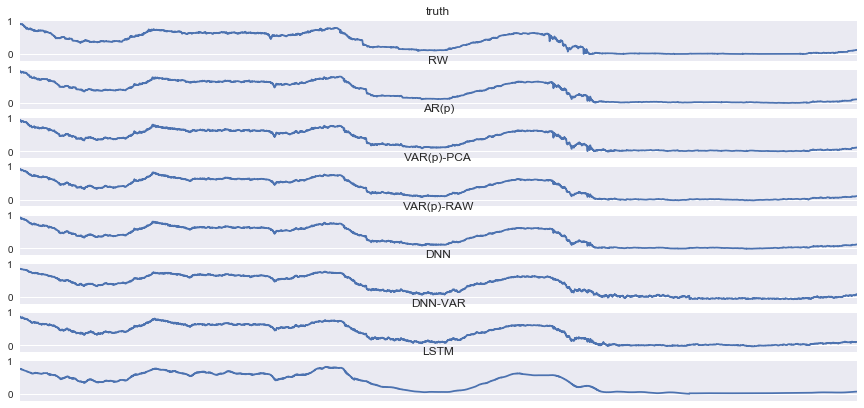

In [292]:
keys = models

plt.figure(figsize=(15,1*len(keys)))
count = 1
plt.subplot(len(keys)+1,1,1)
truth = results["RW"][30][2]
plt.plot(truth)
plt.xlim(0, len(truth))
plt.ylim(-0.2, 1)
plt.title("truth")
plt.xticks([],[])

for k in keys:
    plt.subplot(len(keys)+1,1,count+1)
    plt.plot(results[k][30][1])
    count += 1
    plt.xlim(0, len(truth))
    plt.ylim(-0.2, 1)
    plt.xticks([],[])
    plt.title(k)
    
plt.savefig("prediction.png")
plt.show()

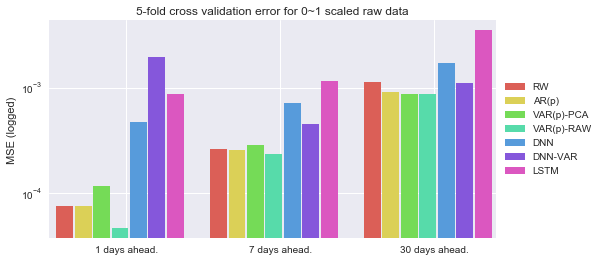

In [291]:
plt.figure(figsize=(8,4))
count = 0
colors = sns.color_palette("hls", len(models))

for m in models:
    d = [results[m][i][0] for i in futures]
    r = [0.12*count+i for i in range(3)]
    plt.bar(r, d, width=0.11, color=colors[count], label=m)
    count += 1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale("log")

plt.xlim(-0.1,2.8)
plt.xticks([],[])
plt.xticks([1.0*(i+1)-0.6 for i in range(3)],[str(f)+" days ahead." for f in futures])

plt.ylabel("MSE (logged)")
plt.title("5-fold cross validation error for 0~1 scaled raw data")
plt.savefig("yieldcurve.png")

plt.show()